# Практика №3

Теперь в качестве акустической модели мы будем использовать простой DNN классификатор. На каждом кадре записи мы будем подавать его вектор признаков на DNN, которая будет выдавать "распределение вероятностей" по фонемам. Далее это распределение мы будем использовать в нашем алгоритме распознавания по словарю. Схема работы такого классификатора представлена ниже: 

![](https://drive.google.com/uc?export=view&id=1dv0VuE8DIoKXETbvnZq2PMixkWMCJOxr)

### Bootstrap

In [1]:
!gdown --id '1meikF0XqBUnVZKoY3160MQ0R25lq-EMu'
!gdown --id '1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox'

!unzip -q lab2.zip
!unzip -q train_librispeech_10h.zip
!mv lab2 lab3
!mv train_librispeech_10h lab3/data
!rm -rf lab2.zip sample_data train_librispeech_10h.zip
%cd lab3

Downloading...
From: https://drive.google.com/uc?id=1meikF0XqBUnVZKoY3160MQ0R25lq-EMu
To: /content/lab2.zip
100% 1.66M/1.66M [00:00<00:00, 26.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox
To: /content/train_librispeech_10h.zip
679MB [00:05, 132MB/s]
/content/lab3


In [2]:
import os
import numpy as np
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
import torch
import torch.nn as nn
import torch.functional as F


%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
# загрузка списка допустимых фонем:
def load_phones_dict(phones_file):
    phones_dict = {}
    with open(phones_file, encoding='utf-8') as fn:
        for index, line in enumerate(fn):
            phones_dict[line.strip()] = index
    return phones_dict

# загрузка покадровой фонемной разметки в словарь:
def load_phone_aligment(aligment_file):
    ali_dict = {}
    with open(aligment_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            ali_dict[line[0]] = line[1:]
    return ali_dict

# подсчет акустиеских признаков для записей из папки:
def load_data_dict(dir_path, count=None):
    data_dict = {}
    step = 0
    for wav_name in tqdm(os.listdir(dir_path)):
        x, sr = librosa.load(os.path.join(dir_path, wav_name), sr=None) 
        mfcc = librosa.feature.mfcc(x, sr=sr, n_mfcc=13, 
                                    n_fft=int(sr * 0.025),
                                    hop_length=int(sr * 0.01))
        step += 1
        if count and step == count:
            print(f'Early stop at {step}th file..')
            break
        data_dict[wav_name.split('.')[0]] = mfcc.T  
    return data_dict


phones_file = 'data/train_librispeech_10h/phones'
phones_dict = load_phones_dict(phones_file)

ali_file = 'data/train_librispeech_10h/ali_phones.txt'
ali_dict = load_phone_aligment(ali_file)

train_records_dir = 'data/train_librispeech_10h/wav_dir'
feats_dict = load_data_dict(train_records_dir, count=1000)

Early stop at 1000th file..


### Априорная вероятность:

![](https://drive.google.com/uc?export=view&id=1WhjclhXm2POYsCgvxp3iAIOvT9F_k8If)

In [4]:
# объединение кадров признаков с соответствующими им фонемам:
def combine_data(ali_dict, feats_dict, phones_dict, side_context=None):
    data_list = []
    priors_list = [0] * len(phones_dict)
    for file_name in feats_dict.keys():
        file_feats = feats_dict[file_name]

        # print(file_feats[0])
        # print(np.tile(file_feats[0], (1, side_context)))
        # print(np.repeat(file_feats[0], 2, axis=0))
        # print(np.tile(file_feats[0], (side_context, 1)))

        # -------------------------------------------------------
        file_ali = ali_dict[file_name]        
        d_range = min(len(file_feats), len(file_ali))

        if side_context: #adding duplicates (side_context times) to the head and tail of file_feats array for easy indexing
            file_feats = np.concatenate((np.tile(file_feats[0], (side_context, 1)), file_feats))
            file_feats = np.concatenate((file_feats, np.tile(file_feats[-1], (side_context, 1))))

        # -------------------------------------------------------
        for frame in range(d_range):
          # -------------------------CONTEXT------------------------------
            if side_context:
              data_list.append(np.append(file_feats[frame : frame + 2 * side_context], phones_dict[file_ali[frame]])) # data_list = feats, number_of_phone_in_dict
            else:     
              data_list.append(np.append(file_feats[frame], phones_dict[file_ali[frame]]))
          # --------------------------------------------------------------                     
            priors_list[phones_dict[file_ali[frame]]] += 1
    return data_list, np.array(priors_list)/sum(priors_list)

side_context = 2
data_list, priors_list = combine_data(ali_dict, feats_dict, phones_dict, side_context)
data_list = np.random.permutation(data_list)

In [5]:
class CommonDataSet():

    def __init__(self, data_list, device, valid_proportion=0.1):
        self.train = data_list[:int((1-valid_proportion)*len(data_list))]
        self.valid = data_list[int((1-valid_proportion)*len(data_list)):]
        self.device = device
        
    def num_batches(self, batch_size):
        return len(self.train)//batch_size        
        
    def next_batch(self, batch_size):
        for i in range(self.num_batches(batch_size)):
            batch_xs = torch.tensor(self.train[i * batch_size:(i + 1) * batch_size, :-1], dtype=torch.float32)
            batch_ys = torch.tensor(self.train[i * batch_size:(i + 1) * batch_size, -1].ravel(), dtype=torch.int64)

            yield batch_xs.to(device), batch_ys.to(device)

In [234]:
class MyNet(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super(MyNet, self).__init__()
        # params:
        input_dim = input_dim       # размерность входных признаков
        n_nodes_hl1 = 256
        n_nodes_hl2 = 256
        n_nodes_hl3 = 256
        n_nodes_hl4 = 256
        output_dim = output_dim     # количество выходных классов (фонем)
        # FC layers:
        self.fc1 = nn.Linear(input_dim, n_nodes_hl1)
        self.fc2 = nn.Linear(n_nodes_hl1, n_nodes_hl2)
        self.fc3 = nn.Linear(n_nodes_hl2, n_nodes_hl3)
        self.fc4 = nn.Linear(n_nodes_hl3, n_nodes_hl4)
        self.fc5 = nn.Linear(n_nodes_hl4, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return (x)

In [298]:
class MyNetTuned(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super(MyNetTuned, self).__init__()
        # params:
        input_dim = input_dim       # размерность входных признаков
        n_nodes_hl1 = 64
        n_nodes_hl2 = 128
        n_nodes_hl3 = 512
        n_nodes_hl4 = 512
        n_nodes_hl5 = 128        
        output_dim = output_dim     # количество выходных классов (фонем)
        # FC layers:
        self.fc1 = nn.Sequential(
                       nn.Linear(input_dim, n_nodes_hl1),
                      #  nn.BatchNorm1d(n_nodes_hl1),
                       nn.ReLU(),
                       )

        self.fc2 = nn.Sequential(
                       nn.Linear(n_nodes_hl1, n_nodes_hl2),                       
                      #  nn.BatchNorm1d(n_nodes_hl2),
                       nn.ReLU(),
                       )

        self.fc3 = nn.Sequential(         
                       nn.Linear(n_nodes_hl2, n_nodes_hl3),
                      #  nn.BatchNorm1d(n_nodes_hl3),
                       nn.ReLU(),
                       )
        
        self.fc4 = nn.Sequential(         
                       nn.Linear(n_nodes_hl3, n_nodes_hl4),
                      #  nn.BatchNorm1d(n_nodes_hl4),                   
                       nn.ReLU(),
                       )
        self.fc5 = nn.Sequential(         
                       nn.Linear(n_nodes_hl3, n_nodes_hl4),
                      #  nn.BatchNorm1d(n_nodes_hl4),                   
                       nn.ReLU(),
                       )
        
        self.fc6 = nn.Linear(n_nodes_hl4, output_dim)


    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        x = self.fc6(x)        
        return (x)

In [299]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data:
data_set = CommonDataSet(data_list, device)

batch_size = 256

# training network model:
start = time.time()

# net = MyNet(input_dim=(data_list[0].shape[0] - 1),
#             output_dim=len(phones_dict.keys())).to(device)

net = MyNetTuned(input_dim=(data_list[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

loss_list = []


lambda1 = lambda epoch: 0.8 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=10, epochs=10)

net.train()
print('TRAINIG IS STARTED...')
for epoch in range(10):
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = net(batch_xs)
        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        counter += 1
        
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)
        
    print('lr = {:.5f}'.format(optimizer.param_groups[0]["lr"]))
    scheduler.step()
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

TRAINIG IS STARTED...



loss is: 1.8821
lr = 0.00100



loss is: 1.7085
lr = 0.00080



loss is: 1.6263
lr = 0.00064



loss is: 1.5580
lr = 0.00051



loss is: 1.4986
lr = 0.00041



loss is: 1.4466
lr = 0.00033



loss is: 1.4009
lr = 0.00026



loss is: 1.3610
lr = 0.00021



loss is: 1.3276
lr = 0.00017



loss is: 1.2993
lr = 0.00013
Time is: 1 min 57 sec


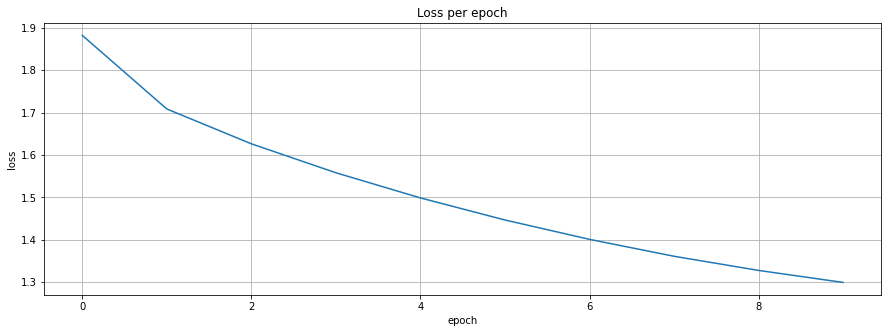

In [300]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(loss_list)
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

In [305]:
net.eval()
net.cpu()
with torch.no_grad():

    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        output = net.forward(ftr)
        # output = net.forward(ftr.unsqueeze(0))
        correct_cnt += (output.argmax().item() == true_label)
        
    print("Total frame accuracy is {:.3f}".format(correct_cnt / data_set.valid.shape[0]))


Total frame accuracy is 0.543


In [312]:
net

MyNetTuned(
  (fc1): Sequential(
    (0): Linear(in_features=52, out_features=64, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU()
  )
  (fc4): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
  )
  (fc5): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
  )
  (fc6): Linear(in_features=512, out_features=86, bias=True)
)

In [306]:
class_correct = [0 for x in range(len(phones_dict.keys()))]
class_total = [0 for x in range(len(phones_dict.keys()))]
net.cpu()
net.eval()
with torch.no_grad():
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        output = net.forward(ftr)
        # output = net.forward(ftr.unsqueeze(0))
        predict_label = output.argmax().item()
        
        class_correct[predict_label] += (predict_label == int(true_label))
        class_total[int(true_label)] += 1

for idx, phone in enumerate(phones_dict.keys()):
    if class_total[idx]:
        print('{:3s}: {:.2f} : {}/{}'.format(phone, class_correct[idx] / class_total[idx], \
                                                     class_correct[idx], class_total[idx]))


SIL: 0.95 : 21645/22755
SPN: 0.06 : 29/527
AA0: 0.13 : 4/31
AA1: 0.48 : 827/1716
AA2: 0.01 : 1/77
AE0: 0.04 : 2/50
AE1: 0.54 : 1940/3598
AE2: 0.17 : 16/93
AH0: 0.32 : 1794/5584
AH1: 0.29 : 545/1886
AH2: 0.02 : 1/60
AO0: 0.23 : 7/30
AO1: 0.50 : 931/1855
AO2: 0.08 : 3/38
AW0: 0.00 : 0/4
AW1: 0.37 : 414/1117
AW2: 0.11 : 4/37
AY0: 0.09 : 3/33
AY1: 0.57 : 1649/2880
AY2: 0.08 : 18/216
B  : 0.29 : 436/1490
CH : 0.26 : 227/861
D  : 0.34 : 1320/3897
DH : 0.24 : 457/1921
EH0: 0.19 : 11/58
EH1: 0.39 : 1098/2834
EH2: 0.02 : 2/87
ER0: 0.39 : 1016/2593
ER1: 0.34 : 312/915
ER2: 0.18 : 2/11
EY0: 0.00 : 0/31
EY1: 0.54 : 1292/2410
EY2: 0.12 : 16/128
F  : 0.59 : 1401/2365
G  : 0.19 : 161/830
HH : 0.37 : 805/2157
IH0: 0.19 : 505/2632
IH1: 0.26 : 582/2250
IH2: 0.01 : 1/105
IY0: 0.41 : 869/2132
IY1: 0.59 : 1362/2294
IY2: 0.00 : 0/54
JH : 0.23 : 149/643
K  : 0.49 : 1472/2991
L  : 0.64 : 2674/4197
M  : 0.47 : 1467/3125
N  : 0.60 : 3481/5807
NG : 0.43 : 566/1314
OW0: 0.08 : 18/225
OW1: 0.41 : 806/1946
OW2: 0.

### Распознавание по словарю с помощью нейронки

In [307]:
# теперь будем распознавать по словарю, состоящему из конечных слов
# для этого нужно загрузить файл лексикона, который определяет из каких фонем состоят наши слова
def load_lexicon_dict(lexicon_file):
    lexicon_dict = {}
    with open(lexicon_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            lexicon_dict[line[0]] = line[1:]
    return lexicon_dict

In [308]:
class AcousticModel:
    def __init__(self, phone_name, phone_index, priors_list):
        self.phone_name = phone_name
        self.phone_index = phone_index
        self.phone_prior = priors_list[phone_index]
        
    def distance(self, input_feats, nnet):
        nnet.eval()
        with torch.no_grad():
            predicts = nnet.forward(torch.tensor(input_feats, dtype=torch.float32))
            softmax = torch.nn.functional.softmax(predicts, dim=0)            

            # predicts = nnet.forward(torch.tensor(input_feats, dtype=torch.float32).unsqueeze(0))
            # softmax = torch.nn.functional.softmax(predicts.squeeze(), dim=0)            

        return -np.log(softmax[self.phone_index].item() / self.phone_prior)

class State:
    def __init__(self, model, index):  
        self.model = model                     # вектор признаков узла
        self.is_final = False                  # является ли этот узел финальнвм в слове
        self.word = None                       # слово эталона (назначается только для финального узла)
        self.best_token = None                 # лучший токен (по минимуму дистанции) в узле
        self.current_word = None               # текущее слово эталона
        self.next_states = []                  # список следующих узлов
        self.index = index                     # индекс узла 

        
def load_graph(lexicon_dict, phones_dict, priors_list):
    start_state = State(None, 0)
    graph = [start_state, ]
    state_index = 1
    for word in lexicon_dict.keys():
        previous_state = start_state
        for phone in lexicon_dict[word]:
            state = State(AcousticModel(phone, phones_dict[phone], priors_list), state_index)
            state.current_word = word           # слово эталона теперь будет храниться в каждом узле
            state.next_states.append(state)     # add loop
            previous_state.next_states.append(state)
            previous_state = state 
            graph.append(state)
            state_index += 1
        if state:
            state.word = word
            state.is_final = True
    return graph

In [309]:
class Token:
    def __init__(self, state, dist=0.0, word=""):
        self.state = state       # стейт графа, в котором токен находится в текущий момент
        self.dist = dist         # общая накопленная дистанция пути, пройденного токеном
        self.word = word         # слово, которое распозналось токеном
        self.alive = True


def beam_pruning(next_tokens, threshold):   
    alive_tokens = [token for token in next_tokens if token.alive]
    best_token = alive_tokens[np.argmin([token.dist for token in alive_tokens if token.alive])]
    for token in next_tokens:
        if token.dist > best_token.dist + threshold:
            token.alive = False
    return next_tokens


def state_pruning(next_tokens):
    for i in range(len(next_tokens)): 
        state_index = next_tokens[i].state.index
        if not graph[state_index].best_token:
            graph[state_index].best_token = next_tokens[i]
        else:
            if next_tokens[i].dist <= graph[state_index].best_token.dist:
                graph[state_index].best_token.alive = False
                graph[state_index].best_token = next_tokens[i]
            else:
                next_tokens[i].alive = False
    for token in next_tokens:                           
        index = token.state.index                        
        if graph[index].best_token:                     
            graph[index].best_token = None              
    return next_tokens


def recognize(filename, features, graph, nnet, recognition_results, beam_threshold, side_context):

    start_state = graph[0]
    active_tokens = [Token(start_state), ]
    next_tokens = []
    
    # -------------------------------------------------------
    d_range = len(features)
    if side_context:
        features = np.concatenate((np.tile(features[0], (side_context, 1)), features))
        features = np.concatenate((features, np.tile(features[-1], (side_context, 1))))
    # -------------------------------------------------------

    for frame in range(d_range):
    # --------------------------------------------------------------
        if side_context:
          ftr_frame = np.ravel(features[frame : frame + 2 * side_context])
        else:
          ftr_frame = features[frame]    
    # --------------------------------------------------------------      


        for token in active_tokens:
            if token.alive:
                for transition_state in token.state.next_states:
                    new_token = Token(transition_state, token.dist, token.word)
                    new_token.dist += transition_state.model.distance(ftr_frame, nnet)
                    next_tokens.append(new_token)
        # state and beam prunings:
        next_tokens = state_pruning(next_tokens)         
        next_tokens = beam_pruning(next_tokens, beam_threshold) 

        active_tokens = next_tokens
        next_tokens = []                                    
        
    # поиск финальных токенов:
    final_tokens = []
    for token in active_tokens:
        if token.state.is_final and token.alive:
            final_tokens.append(token)

    # если нет финальных, то берем лучший из выживших:
    if len(final_tokens) != 0:
        win_token = final_tokens[np.argmin([token.dist for token in final_tokens])]
    else:
        alive_tokens = [token for token in active_tokens if token.alive]
        win_token = alive_tokens[np.argmin([token.dist for token in alive_tokens])]
        win_token.state.word = win_token.state.current_word

    # вывод результата
    print(f"result: {filename:<27} ==> {win_token.state.word}")

    # совпадает ли запись с полученным эталоном:  
    record_word = filename.split('_')[0]
    etalon_word = win_token.state.word.split('_')[0]
    recognition_results.append(etalon_word.lower() == record_word)

    return recognition_results

In [310]:
def run_recognizer(records_data_dict, graph, nnet, beam_threshold=10, side_context=None):
    start_time = time.time()
    recognition_results = []

    for filename in records_data_dict.keys():    
        recognition_results = recognize(filename,
                                        records_data_dict[filename],
                                        graph, nnet,
                                        recognition_results, beam_threshold, 
                                        side_context)

    print("-" * 60)
    print(f"WER is: {(1 - sum(recognition_results)/len(recognition_results))*100:.2f}%")
    print(f"Total time is: {time.time() - start_time:.2f} sec")
    print("-" * 60)

### Запустим распознавание на базе YES_NO

In [313]:
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/yes_no/records")

run_recognizer(records_data_dict, graph, net.cpu(), 100, 2)


result: yes_ff63ab0b_nohash_0       ==> YES
result: no_ad89eb1e_nohash_0        ==> NO
result: no_49af4432_nohash_0        ==> NO
result: no_4abb2400_nohash_0        ==> NO
result: yes_fc94edb0_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: yes_fe1916ba_nohash_0       ==> YES
result: yes_39a6b995_nohash_0       ==> YES
result: yes_39a12648_nohash_0       ==> YES
result: no_4394fc7c_nohash_0        ==> NO
------------------------------------------------------------
WER is: 0.00%
Total time is: 3.56 sec
------------------------------------------------------------


### Запустим распознавание на базе Digits

In [314]:
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/digits/records")

run_recognizer(records_data_dict, graph, net.cpu(), 50, 2)


result: five_f852895b_nohash_0      ==> FIVE
result: two_fce65496_nohash_0       ==> TWO
result: four_fce65496_nohash_0      ==> FOUR
result: one_ffa76c4a_nohash_0       ==> ONE
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
result: zero_f852895b_nohash_0      ==> ZERO
result: seven_fd32732a_nohash_0     ==> SEVEN
result: six_ffd2ba2f_nohash_0       ==> SIX
result: eight_daf230ac_nohash_0     ==> EIGHT
result: six_ffbb695d_nohash_0       ==> SIX
result: two_fb2f3242_nohash_0       ==> TWO
result: three_fce96bac_nohash_0     ==> THREE
result: nine_ccea893d_nohash_0      ==> NINE
result: nine_fbe51750_nohash_0      ==> NINE
result: zero_f92e49f3_nohash_3      ==> ZERO
result: one_fc2411fe_nohash_0       ==> ONE
result: four_ffbb695d_nohash_0      ==> FOUR
result: eight_da584bc0_nohash_4     ==> FIVE
result: three_feb1d305_nohash_0     ==> THREE
------------------------------------------------------------
WER is: 5.00%
Total time is: 28.10 sec


### <b>Задание №1</b> (5 баллов):
Реализовать контексты для входных признаков путем конкатенации кадров слева и справа от текущего. Не забудьте поддержать это и в функции распознавания. Насколько улучшилось качество на дата сетах?

![](https://drive.google.com/uc?export=view&id=1ft0z6CPhX20cJnA373uLoYwHPEagaKyo)

### <b>Задание №2</b> (5 баллов):
Повысить качество классификации фонем за счет улучшения архитектуры нейронной сети, оптимизатора, других речевых признаков и т.п. Составить небольшой отчет на основе результатов перебора использованных способов. 

### **Выводы**

#### Loss for initial model, initial model with context and tuned model with context

**Initial model**:

*   *YES_NO* WER is: 10.00% Total time is: 1.88 sec
*   *DIGITS*: WER is: 10.00% Total time is: 15.66 sec
*   Total frame accuracy is 0.427

**Initial model with side_context=2**:

*   *YES_NO* WER is: 0.00% Total time is: 1.79 sec
*   *DIGITS*: WER is: 10.00% Total time is: 14.87 sec
*   Total frame accuracy is 0.530

**Tuned model with side_context=2**:

*   *YES_NO* WER is: 0.00% Total time is: 3.56 sec
*   *DIGITS*: WER is: 5.00% Total time is: 28.10 sec
*   Total frame accuracy is 0.545


**Model structure**

* initial model
  

> MyNet(  
  (fc1): Linear(in_features=52, out_features=256, bias=True)</br>
  (fc2): Linear(in_features=256, out_features=256, bias=True)</br>
  (fc3): Linear(in_features=256, out_features=256, bias=True)</br>
  (fc4): Linear(in_features=256, out_features=256, bias=True)</br>
  (fc5): Linear(in_features=256, out_features=86, bias=True)</br>
)</br>
lr=0.0001; epoch = 10

* tuned model


> MyNetTuned(
  (fc1): Sequential(
    (0): Linear(in_features=52, out_features=64, bias=True)</br>
    (1): ReLU()</br>
     )</br>
  (fc2): Sequential(</br>
    (0): Linear(in_features=64, out_features=128, bias=True)</br>
    (1): ReLU()</br>
  )</br>
  (fc3): Sequential(</br>
    (0): Linear(in_features=128, out_features=512, bias=True)</br>
    (1): ReLU()</br>
  )</br>
  (fc4): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)</br>
    (1): ReLU()</br>
  )</br>
  (fc5): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)</br>
    (1): ReLU()</br>
  )</br>
  (fc6): Linear(in_features=512, out_features=86, bias=True)</br>
)


lr=0.01 + scheduler; epoch = 10

Добавление контекста в 2 элемента слева и 2 справа дало улучшение Total frame accuracy с 0.427 до 0.530. WER для базы YES_NO упал до 0. Для базы Digits остался на том же уровне.

Изменения количества выходов в слоях, добавление еще одного линейного слоя и изменения learning rate по мере обучения позволили несколько повысить качество на тех же 10 эпохах. Требуется обучение на большем количестве эпох и примеров.


In [32]:
loss_list1 = [2.2895099223531283,
 2.1613965477331156,
 2.123964927076945,
 2.099247404557012,
 2.080394889575486,
 2.0648582380274214,
 2.0514665953840114,
 2.0394286365221665,
 2.0285618747784526,
 2.0184083995536013]

In [33]:
loss_list2 = [2.020500488513932,
 1.8110207935813198,
 1.740243820064331,
 1.6947337993214793,
 1.6607957936845148,
 1.6336046595613098,
 1.6107284202183234,
 1.5907735694304515,
 1.5731381240629845,
 1.557368097880033]

In [302]:
loss_list3 = [1.8820791330824334,
 1.7084618537431893,
 1.6262723490820323,
 1.557984026678766,
 1.4986444977071276,
 1.4465610153733517,
 1.4009043388965023,
 1.360999699064606,
 1.3275815198628962,
 1.2992514526010337]

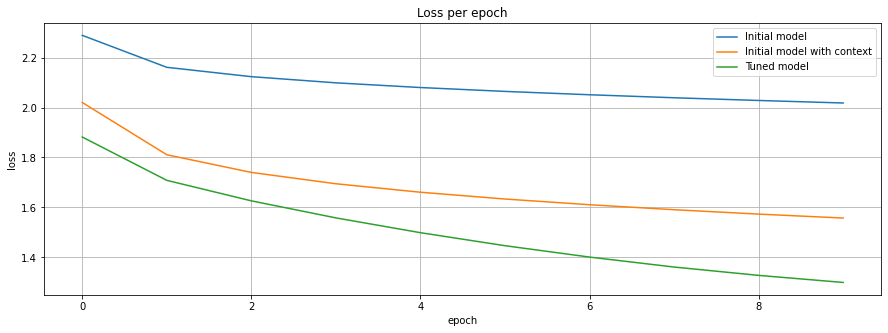

In [304]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(loss_list1)
plt.plot(loss_list2)
plt.plot(loss_list3)
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['Initial model', 'Initial model with context', 'Tuned model'])
plt.show()